![title](https://i.ibb.co/f2W87Fg/logo2020.png)

---


# Task 2 - Image Classification via Feature Space

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.


---
---
## 0 - Import necessary libraries and informations

In [1]:
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt

from scipy.ndimage import uniform_filter
from sklearn.metrics import accuracy_score
%matplotlib inline

np.set_printoptions(precision=8)

Write down your Name and Student ID

In [2]:
## --- start your code here ----

NIM  = 1301170073
Nama = "Pratama Yoga Santosa"

## --- end your code here ----

---
---
## 1 - Load CIFAR-10 Dataset

* First, Obtain Cifar-10 dataset.
  There are from various source in Internet like [Keras](https://keras.io/datasets/), [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/datasets), or any other source
* Next you will prepare the dataset by first:
 * visualizing data
 * split into training, validation, and testing set
 * normalize data

---
### a. Import Data ***CIFAR-10***

In [3]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'forse', 'ship', 'truck']


170500096/170498071 [==============================] - 2s 0us/step


Check your implementation

In [4]:
print('X_train.shape =',X_train.shape)
print('y_train.shape =',y_train.shape)
print('X_test.shape  =',X_test.shape)
print('y_test.shape  =',y_test.shape)

X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
X_test.shape  = (10000, 32, 32, 3)
y_test.shape  = (10000, 1)


**Expected Output**: 
<pre>
X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
X_test.shape  = (10000, 32, 32, 3)
y_test.shape  = (10000, 1)


---
### b. Visualizing Data


Show the first 20 images from X_train

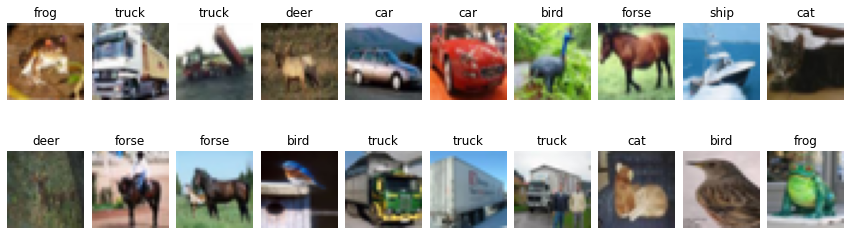

In [5]:
fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(X_train[i+j*10])
        ax[j,i].set_title(classes[y_train[i+j*10,0]])
        ax[j,i].axis('off')
plt.show()

---
### c. Split Training Data

Cut the `last 10000 data` from `Training Set`, and save it as `Validation Set`

In [6]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

X_val = X_train[-10000:,:]
y_val = y_train[-10000:]

X_train = X_train[:-10000, :]
y_train = y_train[:-10000]

---
---
## 2 - Feature Extraction Functions

For each image we will compute a Histogram of Oriented Gradients (HOG) as well as a color histogram using the hue channel in HSV color space. We form our final feature vector for each image by concatenating the HOG and color histogram feature vectors.

Here we already defined for you the implementation of HOG and Color Histogram. Read it carefully to understand it.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The `extract_features`
function takes a set of mages and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

---
### a. Histogram of Oriented Gradients

Roughly speaking, HOG should capture the texture of the image while ignoring color information. The code below is a modified from [skimage.feature.hog](http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog)

Read further: Histograms of Oriented Gradients for Human Detection, Navneet Dalal and Bill Triggs, CVPR 2005

In [7]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [8]:
def hog_feature(im):

    # convert rgb to grayscale if needed
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)

    sx, sy = image.shape # image size
    orientations = 9 # number of gradient bins
    cx, cy = (8, 8) # pixels per cell

    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)

    # compute gradient on x-direction
    gx[:, :-1] = np.diff(image, n=1, axis=1) 
    # compute gradient on y-direction
    gy[:-1, :] = np.diff(image, n=1, axis=0) 

    # gradient magnitude
    grad_mag = np.sqrt(gx ** 2 + gy ** 2) 

    # gradient orientation
    grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90 

    n_cellsx = int(np.floor(sx / cx))  # number of cells in x
    n_cellsy = int(np.floor(sy / cy))  # number of cells in y

    # compute orientations integral images
    orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))

    for i in range(orientations):
        # create new integral image for this orientation
        # isolate orientations in this range
        temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                            grad_ori, 0)
        temp_ori = np.where(grad_ori >= 180 / orientations * i,
                            temp_ori, 0)
        
        # select magnitudes for those orientations
        cond2 = temp_ori > 0
        temp_mag = np.where(cond2, grad_mag, 0)
        orientation_histogram[:,:,i] = uniform_filter(temp_mag, size=(cx, cy))[round(cx/2)::cx, round(cy/2)::cy].T

    return orientation_histogram.ravel()

---
### b. Color Histogram

Compared to HOG, the color histogram represents the color of the input image while ignoring texture. As a result, we expect that using both together ought to work better than using either alone. Verifying this assumption would be a good thing to try for your own interest.

In [9]:
def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True):

    ndim = im.ndim
    bins = np.linspace(xmin, xmax, nbin+1)

    hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
    imhist, bin_edges = np.histogram(hsv[:,:,0], bins=bins, density=normalized)

    imhist = imhist * np.diff(bin_edges)

    return imhist


---
### c. Extract Feature Helper Function

Given pixel data for images and several feature functions that can operate on single images, apply all feature functions to all images, concatenating the feature vectors for each image and storing the features for all images in a single matrix. This function returns an array of shape (N, F_1 + ... + F_k) where each column is the concatenation of all features for a single image.

In [10]:
def extract_features(imgs, feature_fns, verbose=False):
 
    num_images = imgs.shape[0]
    if num_images == 0:
        return np.array([])

    # Use the first image to determine feature dimensions
    feature_dims = []
    first_image_features = []
    for feature_fn in feature_fns:
        feats = feature_fn(imgs[0].squeeze())
        assert len(feats.shape) == 1, 'Feature functions must be one-dimensional'
        feature_dims.append(feats.size)
        first_image_features.append(feats)

    # Now that we know the dimensions of the features, we can allocate a single
    # big array to store all features as columns.
    total_feature_dim = sum(feature_dims)
    imgs_features = np.zeros((num_images, total_feature_dim))
    imgs_features[0] = np.hstack(first_image_features).T

    # Extract features for the rest of the images.
    for i in range(1, num_images):
        idx = 0
        for feature_fn, feature_dim in zip(feature_fns, feature_dims):
            next_idx = idx + feature_dim
            imgs_features[i, idx:next_idx] = feature_fn(imgs[i].squeeze())
            idx = next_idx
        if verbose and i % 1000 == 999:
            print('Done extracting features for %d / %d images' % (i+1, num_images))

    return imgs_features

---
---
## 3 - Extract and Normalize Feature

---
### a. Extract Features

In [11]:
num_color_bins = 10 # Number of bins in the color histogram

feature_fns   = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats   = extract_features(X_val, feature_fns)
X_test_feats  = extract_features(X_test, feature_fns)

Done extracting features for 1000 / 40000 images
Done extracting features for 2000 / 40000 images
Done extracting features for 3000 / 40000 images
Done extracting features for 4000 / 40000 images
Done extracting features for 5000 / 40000 images
Done extracting features for 6000 / 40000 images
Done extracting features for 7000 / 40000 images
Done extracting features for 8000 / 40000 images
Done extracting features for 9000 / 40000 images
Done extracting features for 10000 / 40000 images
Done extracting features for 11000 / 40000 images
Done extracting features for 12000 / 40000 images
Done extracting features for 13000 / 40000 images
Done extracting features for 14000 / 40000 images
Done extracting features for 15000 / 40000 images
Done extracting features for 16000 / 40000 images
Done extracting features for 17000 / 40000 images
Done extracting features for 18000 / 40000 images
Done extracting features for 19000 / 40000 images
Done extracting features for 20000 / 40000 images
Done extr

---
### b. Subtract Mean

##### <font color='red'>**EXERCISE**: </font>
* Normalize `X_train_feats`, `X_val_feats`, and `X_test_feats` by *zero-centering* them:
    * calculate the `mean` of training data `X_train_feats`
    * subtract `X_train_feats`, `X_val_feats`, and `X_test_feats` using mean of `X_train_feats`
    * use `np.mean()` with `axis=0` and `keepdims=True` to calculate the standard deviation

In [12]:
mean_feat      = np.mean(X_train_feats, axis=0, keepdims=True)

X_train_feats -= mean_feat
X_val_feats   -= mean_feat
X_test_feats  -= mean_feat

Check your implementation

In [13]:
print('np.mean(X_train_feats) =',np.mean(X_train_feats))
print('np.mean(X_val_feats)   =',np.mean(X_val_feats))
print('np.mean(X_test_feats)  =',np.mean(X_test_feats))

np.mean(X_train_feats) = -1.8848760935890657e-16
np.mean(X_val_feats)   = -0.007372060535654032
np.mean(X_test_feats)  = -0.002616707164937622


**Expected Output**: 
<pre>np.mean(X_train_feats) = -1.8848760935890657e-16
np.mean(X_val_feats)   = -0.007372060535654032
np.mean(X_test_feats)  = -0.002616707164937622

---
### c. Divide by STD

Divide by standard deviation. This ensures that each feature has roughly the same scale.


#####<font color='red'>**EXERCISE**: </font>
* Divide `X_train_feats`, `X_val_feats`, and `X_test_feats` by the standard deviation of `X_train_feats`
* use `np.std()` with `axis=0` and `keepdims=True` to calculate the standard deviation

In [14]:
std_feat       = np.std(X_train_feats,axis=0, keepdims=True)

X_train_feats  /= std_feat
X_val_feats    /= std_feat
X_test_feats   /= std_feat


Check your implementation

In [15]:
print('np.mean(X_train_feats) =',np.mean(X_train_feats))
print('np.mean(X_val_feats)   =',np.mean(X_val_feats))
print('np.mean(X_test_feats)  =',np.mean(X_test_feats))

np.mean(X_train_feats) = -2.6402660721516865e-16
np.mean(X_val_feats)   = -0.004088128603644509
np.mean(X_test_feats)  = -0.0009327328073588954


**Expected Output**: 
<pre>np.mean(X_train_feats) = -2.6402660721516865e-16
np.mean(X_val_feats)   = -0.004088128603644509
np.mean(X_test_feats)  = -0.0009327328073588954

---
### d. Stack feature data

In [16]:
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats   = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats  = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

---
---
##4 - Normalize RAW Pixel Data

Let's also normalize the raw pixel data as comparison

In [17]:
mean_image = np.mean(X_train, axis = 0)
X_train -= mean_image
X_val   -= mean_image
X_test  -= mean_image

X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
X_val   = X_val.reshape((X_val.shape[0],X_val.shape[1]*X_val.shape[2]*X_val.shape[3]))
X_test  = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))

y_train = y_train.ravel()
y_val   = y_val.ravel()
y_test  = y_test.ravel()

---
---
## 5 - Linear Function
These parts are exactly the same as previous exercise,
so we'll provide you the result

---
### a. Forward Function


In [18]:
def forward(x, W, b):  
    v = np.dot(x, W) + b
    return v

---
### b. Backward Function

In [19]:
def backward(dout, x, W, b):
    
    dW = np.dot(x.T,dout)
    db = np.sum(dout, axis=0, keepdims=True)
    dx = dout.dot(W.T)
    
    return dW, db, dx

---
---
## 6 - Loss Functions

---
### a. Softmax Loss

In [20]:
def softmax_loss(score, y):   
    
    score -= np.max(score)
    score_exp = np.exp(score)
    score_sum = np.sum(score_exp, axis = 1, keepdims = True)
    score = score_exp / score_sum

    num_examples = score.shape[0]
        
    number_list = range(num_examples)
    corect_logprobs = -np.log(score[number_list,y])
    loss = np.sum(corect_logprobs)/num_examples

    dscores = score
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    return loss, dscores

---
### b. SVM Loss

In [21]:
def svm_loss(score, y):
    num_examples = score.shape[0]
    
    correct_scores = np.choose(y,score.T)
    margin = score.T - correct_scores + 1
    margin = np.maximum(0,margin)
    loss_i = np.sum(margin) - num_examples
    loss = loss_i/num_examples
    dscores = (margin.T > 0).astype(float)
    marginsSum = dscores.sum(1) - 1
    dscores[range(dscores.shape[0]), y] = -marginsSum
        
    return loss, dscores

---
---
## 7 - Linear Classifier


---
### a. Weight Initialization

In [22]:
def initialize_weights(n, d, std):
    
    W = std * np.random.randn(n, d)
    b = np.zeros((1,d))
    
    return W, b

---
### b. Training Function

In [23]:
def train(X, y, W=None, b=None, learning_rate=1e-6, reg=1e4, num_iters=100, batch_size=200, verbose=False, loss_fn=softmax_loss):
    
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    num_train, dim = X.shape
    
    if W is None:
        W, b = initialize_weights(dim, num_classes, 0.001)

    loss_history = []
                     
    for it in range(num_iters):
        X_batch = None
        y_batch = None

        train_rows = np.arange(num_train)
        idxs = np.random.choice(train_rows, batch_size, replace=False)
  
        X_batch = X[idxs]
        y_batch = y[idxs]

        scores = forward(X_batch, W, b)        
        loss, dout = loss_fn(scores, y_batch)
        loss_history.append(loss)

        dW, db, _ = backward(dout, X_batch, W, b)
        dW += reg*W
        
        W -= learning_rate * dW
        b -= learning_rate * db
        
        if verbose and it % 100 == 0:
            print ('iteration', it,'/',num_iters, ': loss =', loss)
    return loss_history, W, b

---
### c. Predict Function

In [24]:
def predict(X, W, b):    

    y_pred = np.zeros(X.shape[1])
    y_pred = forward(X, W, b)
    y_pred = y_pred.argmax(axis=-1)
    
    return y_pred

---
---
##8 - Train Softmax 

---
###a. Train on Raw Pixel
* Find the best Learning Rate and Regularization Strength




##### <font color='red'>**EXERCISE**: </font>     
* experiment with different ranges for the learning rates and regularization strengths; 

In [25]:
import warnings
warnings.filterwarnings('ignore')
np.random.seed(None)

results = {}
best_val = -1
best_W = None
best_b = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [9e4, 1e5]

iterations = 2000

# Greedily loop over learning_rates and regularization_strengths
for rate in learning_rates:
    for reg in regularization_strengths:
        print('Running {} iterations, rate = {}, reg = {}'.format(iterations, rate, reg))
        # call train function using the learning rate and regularization selected
        loss, W, b = train(X_train, y_train, 
                           learning_rate=rate, reg=reg,
                           num_iters=iterations, verbose=False,
                           loss_fn=softmax_loss)
        
        # call predict function using pretrained W and b on X_train and X_val to evaluate
        y_train_pred = predict(X_train, W, b)
        y_val_pred   = predict(X_val, W, b)
        
        # calculate the accuracy
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        print ('rate = {}, reg = {}, test accuracy = {}, validation accuracy = {}'.format(
            rate, reg, train_accuracy, val_accuracy))
        
        # store the result accuracy combination
        results[(rate, reg)] = (train_accuracy, val_accuracy)
        
        # store the best Weight and Bias
        if val_accuracy > best_val:
            best_W = W
            best_b = b
            best_val = val_accuracy


    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr',lr,',reg',reg,', train accuracy: ',train_accuracy*100,'%, val accuracy: ', val_accuracy ,'%')
    
print()
print('best validation accuracy achieved during cross-validation:',best_val*100,'%')
print('best Weights and bias are stored in `best_W` and `best_b`')

Running 2000 iterations, rate = 1e-07, reg = 90000.0
rate = 1e-07, reg = 90000.0, test accuracy = 0.310075, validation accuracy = 0.3069
Running 2000 iterations, rate = 1e-07, reg = 100000.0
rate = 1e-07, reg = 100000.0, test accuracy = 0.3037, validation accuracy = 0.3009
Running 2000 iterations, rate = 5e-07, reg = 90000.0
rate = 5e-07, reg = 90000.0, test accuracy = 0.30645, validation accuracy = 0.3048
Running 2000 iterations, rate = 5e-07, reg = 100000.0
rate = 5e-07, reg = 100000.0, test accuracy = 0.30455, validation accuracy = 0.3012
lr 1e-07 ,reg 90000.0 , train accuracy:  31.0075 %, val accuracy:  0.3069 %
lr 1e-07 ,reg 100000.0 , train accuracy:  30.37 %, val accuracy:  0.3009 %
lr 5e-07 ,reg 90000.0 , train accuracy:  30.645 %, val accuracy:  0.3048 %
lr 5e-07 ,reg 100000.0 , train accuracy:  30.455 %, val accuracy:  0.3012 %

best validation accuracy achieved during cross-validation: 30.69 %
best Weights and bias are stored in `best_W` and `best_b`


**Expected Output**:

if you are careful you should be able to get a classification accuracy of **over 35%** on the validation set


---
###b. Test the Trained Weights

In [26]:
y_pred   = predict(X_test, best_W, best_b)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('Testing Accuracy =', accuracy*100,'%')
print('Test label      =',y_test[:15])
print('Predicted label =',y_pred[:15])

Testing Accuracy = 31.45 %
Test label      = [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9]
Predicted label = [6 8 8 8 5 6 6 6 0 8 0 9 6 6 9]


---
###c. Train on Features
* Find the best Learning Rate and Regularization Strength
* * Train the Classifier with Softmax Loss on top of the features extracted above; this should achieve better results than training Softmax directly on top of raw pixels.




##### <font color='red'>**EXERCISE**: </font>     
* experiment with different ranges for the learning rates and regularization strengths; 
* You might also want to play with different numbers of bins in the color histogram.

In [27]:
import warnings
warnings.filterwarnings('ignore')
np.random.seed(None)

results = {}
best_val = -1
best_W_feats = None
best_b_feats = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [9e4, 1e5]

iterations = 2000

# Greedily loop over learning_rates and regularization_strengths
for rate in learning_rates:
    for reg in regularization_strengths:
        print('Running {} iterations, rate = {}, reg = {}'.format(iterations, rate, reg))
        # call train function using the learning rate and regularization selected
        loss, W, b = train(X_train_feats, y_train, 
                           learning_rate=rate, reg=reg,
                           num_iters=iterations, verbose=False,
                           loss_fn=softmax_loss)
        
        # call predict function using pretrained W and b on X_train_feats and X_val_feats to evaluate
        y_train_pred = predict(X_train_feats, W, b)
        y_val_pred   = predict(X_val_feats, W, b)
        
        # calculate the accuracy
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        print ('rate = {}, reg = {}, test accuracy = {}, validation accuracy = {}'.format(
            rate, reg, train_accuracy, val_accuracy))
        
        # store the result accuracy combination
        results[(rate, reg)] = (train_accuracy, val_accuracy)
        
        # store the best Weight and Bias
        if val_accuracy > best_val:
            best_W_feats = W
            best_b_feats = b
            best_val = val_accuracy


    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr',lr,',reg',reg,', train accuracy: ',train_accuracy*100,'%, val accuracy: ', val_accuracy ,'%')
    
print()
print('best validation accuracy achieved during cross-validation:',best_val*100,'%')
print('best Weights and bias are stored in `best_W_feats` and `best_b_feats`')

Running 2000 iterations, rate = 1e-07, reg = 90000.0
rate = 1e-07, reg = 90000.0, test accuracy = 0.41235, validation accuracy = 0.4062
Running 2000 iterations, rate = 1e-07, reg = 100000.0
rate = 1e-07, reg = 100000.0, test accuracy = 0.4117, validation accuracy = 0.4045
Running 2000 iterations, rate = 5e-07, reg = 90000.0
rate = 5e-07, reg = 90000.0, test accuracy = 0.401325, validation accuracy = 0.3921
Running 2000 iterations, rate = 5e-07, reg = 100000.0
rate = 5e-07, reg = 100000.0, test accuracy = 0.410725, validation accuracy = 0.4016
lr 1e-07 ,reg 90000.0 , train accuracy:  41.235 %, val accuracy:  0.4062 %
lr 1e-07 ,reg 100000.0 , train accuracy:  41.17 %, val accuracy:  0.4045 %
lr 5e-07 ,reg 90000.0 , train accuracy:  40.1325 %, val accuracy:  0.3921 %
lr 5e-07 ,reg 100000.0 , train accuracy:  41.0725 %, val accuracy:  0.4016 %

best validation accuracy achieved during cross-validation: 40.62 %
best Weights and bias are stored in `best_W_feats` and `best_b_feats`


**Expected Output**:

if you are careful you should be able to get a classification accuracy of **near 44%** on the validation set


---
###d. Test the Trained Weights


In [28]:
y_pred   = predict(X_test_feats, best_W_feats, best_b_feats)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('Testing Accuracy =', accuracy*100,'%')
print('Test label      =',y_test[:15])
print('Predicted label =',y_pred[:15])

Testing Accuracy = 41.260000000000005 %
Test label      = [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9]
Predicted label = [5 1 8 8 6 6 6 0 3 9 0 9 6 6 9]


**Expected Output**:

You should reach at least  **42%** accuracy on test set


---
---
##9 - Train Multiclass SVM 

---
###a. Train on Raw Pixel
* Find the best Learning Rate and Regularization Strength




##### <font color='red'>**EXERCISE**: </font>     
* experiment with different ranges for the learning rates and regularization strengths; 

In [29]:
import warnings
warnings.filterwarnings('ignore')
np.random.seed(None)

results = {}
best_val = -1
best_W = None
best_b = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [9e4, 1e5]

iterations = 2000

# Greedily loop over learning_rates and regularization_strengths
for rate in learning_rates:
    for reg in regularization_strengths:
        print('Running {} iterations, rate = {}, reg = {}'.format(iterations, rate, reg))
        # call train function using the learning rate and regularization selected
        loss, W, b = train(X_train, y_train, 
                           learning_rate=rate, reg=reg,
                           num_iters=iterations, verbose=False,
                           loss_fn=svm_loss)
        
        # call predict function using pretrained W and b on X_train and X_val to evaluate
        y_train_pred = predict(X_train, W, b)
        y_val_pred   = predict(X_val, W, b)
        
        # calculate the accuracy
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        print ('rate = {}, reg = {}, test accuracy = {}, validation accuracy = {}'.format(
            rate, reg, train_accuracy, val_accuracy))
        
        # store the result accuracy combination
        results[(rate, reg)] = (train_accuracy, val_accuracy)
        
        # store the best Weight and Bias
        if val_accuracy > best_val:
            best_W = W
            best_b = b
            best_val = val_accuracy


    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr',lr,',reg',reg,', train accuracy: ',train_accuracy*100,'%, val accuracy: ', val_accuracy ,'%')
    
print()
print('best validation accuracy achieved during cross-validation:',best_val*100,'%')
print('best Weights and bias are stored in `best_W` and `best_b`')

Running 2000 iterations, rate = 1e-07, reg = 90000.0
rate = 1e-07, reg = 90000.0, test accuracy = 0.25615, validation accuracy = 0.2425
Running 2000 iterations, rate = 1e-07, reg = 100000.0
rate = 1e-07, reg = 100000.0, test accuracy = 0.262125, validation accuracy = 0.2589
Running 2000 iterations, rate = 5e-07, reg = 90000.0
rate = 5e-07, reg = 90000.0, test accuracy = 0.22535, validation accuracy = 0.2313
Running 2000 iterations, rate = 5e-07, reg = 100000.0
rate = 5e-07, reg = 100000.0, test accuracy = 0.215, validation accuracy = 0.2107
lr 1e-07 ,reg 90000.0 , train accuracy:  25.615 %, val accuracy:  0.2425 %
lr 1e-07 ,reg 100000.0 , train accuracy:  26.2125 %, val accuracy:  0.2589 %
lr 5e-07 ,reg 90000.0 , train accuracy:  22.535 %, val accuracy:  0.2313 %
lr 5e-07 ,reg 100000.0 , train accuracy:  21.5 %, val accuracy:  0.2107 %

best validation accuracy achieved during cross-validation: 25.89 %
best Weights and bias are stored in `best_W` and `best_b`


**Expected Output**:

You should reach `at least`  **`30%`** accuracy on cross-validation

---
###b. Test the Trained Weights

In [30]:
y_pred = predict(X_test, best_W, best_b)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('Testing Accuracy =', accuracy*100,'%')
print('Test label      =',y_test[:15])
print('Predicted label =',y_pred[:15])

Testing Accuracy = 26.25 %
Test label      = [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9]
Predicted label = [6 8 8 0 4 6 6 4 0 1 8 8 4 4 1]


---
###c. Train on Features
* Find the best Learning Rate and Regularization Strength
* Train the Classifier with SVM Loss on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.



#####<font color='red'>**EXERCISE**: </font>
* Experiment with different ranges for the learning rates and regularization strengths; 
* You might also want to play with different numbers of bins in the color histogram.

In [31]:
import warnings
warnings.filterwarnings('ignore')
np.random.seed(None)

results = {}
best_val = -1
best_W_feats = None
best_b_feats = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [9e4, 1e5]

iterations = 2000

# Greedily loop over learning_rates and regularization_strengths
for rate in learning_rates:
    for reg in regularization_strengths:
        print('Running {} iterations, rate = {}, reg = {}'.format(iterations, rate, reg))
        # call train function using the learning rate and regularization selected
        loss, W, b = train(X_train_feats, y_train, 
                           learning_rate=rate, reg=reg,
                           num_iters=iterations, verbose=False,
                           loss_fn=svm_loss)
        
        # call predict function using pretrained W and b on X_train_feats and X_val_feats to evaluate
        y_train_pred = predict(X_train_feats, W, b)
        y_val_pred   = predict(X_val_feats, W, b)
        
        # calculate the accuracy
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        print ('rate = {}, reg = {}, test accuracy = {}, validation accuracy = {}'.format(
            rate, reg, train_accuracy, val_accuracy))
        
        # store the result accuracy combination
        results[(rate, reg)] = (train_accuracy, val_accuracy)
        
        # store the best Weight and Bias
        if val_accuracy > best_val:
            best_W_feats = W
            best_b_feats = b
            best_val = val_accuracy


    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr',lr,',reg',reg,', train accuracy: ',train_accuracy*100,'%, val accuracy: ', val_accuracy ,'%')
    
print()
print('best validation accuracy achieved during cross-validation:',best_val*100,'%')
print('best Weights and bias are stored in `best_W_feats` and `best_b_feats`')

Running 2000 iterations, rate = 1e-07, reg = 90000.0
rate = 1e-07, reg = 90000.0, test accuracy = 0.416875, validation accuracy = 0.41
Running 2000 iterations, rate = 1e-07, reg = 100000.0
rate = 1e-07, reg = 100000.0, test accuracy = 0.4213, validation accuracy = 0.4136
Running 2000 iterations, rate = 5e-07, reg = 90000.0
rate = 5e-07, reg = 90000.0, test accuracy = 0.4092, validation accuracy = 0.4036
Running 2000 iterations, rate = 5e-07, reg = 100000.0
rate = 5e-07, reg = 100000.0, test accuracy = 0.390875, validation accuracy = 0.3807
lr 1e-07 ,reg 90000.0 , train accuracy:  41.6875 %, val accuracy:  0.41 %
lr 1e-07 ,reg 100000.0 , train accuracy:  42.13 %, val accuracy:  0.4136 %
lr 5e-07 ,reg 90000.0 , train accuracy:  40.92 %, val accuracy:  0.4036 %
lr 5e-07 ,reg 100000.0 , train accuracy:  39.0875 %, val accuracy:  0.3807 %

best validation accuracy achieved during cross-validation: 41.36 %
best Weights and bias are stored in `best_W_feats` and `best_b_feats`


**Expected Output**:

if you are careful you should be able to get a classification accuracy of **near 42%** on the validation set


---
###d. Test the Trained Weights


In [32]:
y_pred = predict(X_test_feats, best_W_feats, best_b_feats)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('Testing Accuracy =', accuracy*100,'%')
print('Test label      =',y_test[:15])
print('Predicted label =',y_pred[:15])

Testing Accuracy = 41.6 %
Test label      = [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9]
Predicted label = [5 1 0 8 6 6 6 2 3 9 0 9 6 6 9]


**Expected Output**:

You should reach at least  **40%** accuracy on test set


---

# Congratulation, You've Completed Exercise 2

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>

![footer](https://i.ibb.co/yX0jfMS/footer2020.png)